In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Colab Notebooks/Kaggle"

import os
%cd "/content/gdrive/My Drive/Colab Notebooks/Kaggle"

/content/gdrive/My Drive/Colab Notebooks/Kaggle


In [ ]:
!kaggle competitions download -c cap-4611-spring-21-assignment-3

train.csv: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
test.csv: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import numpy as np 
import pandas as pd 
from sklearn import metrics
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn import naive_bayes
from sklearn.preprocessing import PowerTransformer

In [ ]:
data = pd.read_csv("train.csv")
data.head()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,diagnosis
0,0,14.48,21.46,94.25,648.2,0.09444,0.09947,0.120400,0.04938,0.2075,0.05636,0.4204,2.2200,3.301,38.87,0.009369,0.029830,0.05371,0.017610,0.02418,0.003249,16.21,29.25,108.40,808.9,0.1306,0.19760,0.33490,0.1225,0.3020,0.06846,1
1,1,14.92,14.93,96.45,686.9,0.08098,0.08549,0.055390,0.03221,0.1687,0.05669,0.2446,0.4334,1.826,23.31,0.003271,0.017700,0.02310,0.008399,0.01148,0.002379,17.18,18.22,112.00,906.6,0.1065,0.27910,0.31510,0.1147,0.2688,0.08273,0
2,2,12.81,13.06,81.29,508.8,0.08739,0.03774,0.009193,0.01330,0.1466,0.06133,0.2889,0.9899,1.778,21.79,0.008534,0.006364,0.00618,0.007408,0.01065,0.003351,13.63,16.15,86.70,570.7,0.1162,0.05445,0.02758,0.0399,0.1783,0.07319,0
3,3,13.20,17.43,84.13,541.6,0.07215,0.04524,0.043360,0.01105,0.1487,0.05635,0.1630,1.6010,0.873,13.56,0.006261,0.015690,0.03079,0.005383,0.01962,0.002250,13.94,27.82,88.28,602.0,0.1101,0.15080,0.22980,0.0497,0.2767,0.07198,0
4,4,12.47,17.31,80.45,480.1,0.08928,0.07630,0.036090,0.02369,0.1526,0.06046,0.1532,0.7810,1.253,11.91,0.003796,0.013710,0.01346,0.007096,0.01536,0.001541,14.06,24.34,92.82,607.3,0.1276,0.25060,0.20280,0.1053,0.3035,0.07661,0


In [ ]:
data.describe()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,diagnosis
count,284.000000,284.000000,284.000000,284.00000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000
mean,141.500000,14.133384,19.354824,91.96331,656.370423,0.095307,0.102288,0.088245,0.047708,0.180214,0.062251,0.395850,1.221463,2.799136,38.974380,0.007036,0.025967,0.033004,0.011738,0.020623,0.003875,16.248229,25.865739,107.215493,880.827817,0.130850,0.252964,0.276384,0.113469,0.288513,0.083050,0.373239
std,82.127949,3.557272,4.308783,24.44977,353.886842,0.014372,0.050656,0.079657,0.038772,0.026448,0.007089,0.237095,0.534399,1.676412,36.551638,0.003142,0.018662,0.035852,0.006575,0.008063,0.003137,4.883497,6.152410,34.022758,580.281025,0.022626,0.159129,0.217757,0.066945,0.058428,0.018022,0.484519
min,0.000000,6.981000,9.710000,43.79000,143.500000,0.062510,0.019380,0.000000,0.000000,0.106000,0.049960,0.114400,0.406400,0.771400,6.802000,0.002838,0.002252,0.000000,0.000000,0.010290,0.000895,7.930000,12.020000,50.410000,185.200000,0.081250,0.034320,0.000000,0.000000,0.156600,0.055210,0.000000
25%,70.750000,11.807500,16.060000,76.09750,428.675000,0.084668,0.062740,0.029640,0.019603,0.161775,0.057068,0.236450,0.856775,1.667000,17.967500,0.005298,0.012828,0.015030,0.007482,0.015017,0.002225,12.977500,21.382500,83.722500,512.450000,0.114300,0.145325,0.118475,0.062563,0.250300,0.071145,0.000000
50%,141.500000,13.205000,18.945000,85.25000,540.250000,0.094155,0.093435,0.061745,0.033025,0.178300,0.061115,0.327500,1.094000,2.330000,24.950000,0.006302,0.020625,0.026245,0.010850,0.019030,0.003044,14.995000,25.580000,97.665000,683.600000,0.129450,0.211600,0.229800,0.097355,0.280950,0.078650,0.000000
75%,212.250000,16.132500,21.825000,106.45000,799.100000,0.104825,0.127975,0.127700,0.070468,0.194425,0.065410,0.476050,1.478500,3.274000,44.467500,0.007989,0.033247,0.040697,0.014672,0.024202,0.004328,18.247500,30.127500,124.475000,1031.250000,0.144550,0.321725,0.386550,0.162925,0.311575,0.091482,1.000000
max,283.000000,27.220000,32.470000,182.10000,2250.000000,0.163400,0.286700,0.426800,0.201200,0.274300,0.095020,1.509000,3.896000,9.807000,233.000000,0.031130,0.106400,0.396000,0.052790,0.061460,0.029840,33.130000,47.160000,229.300000,3432.000000,0.218400,1.058000,1.252000,0.286700,0.577400,0.207500,1.000000


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284 entries, 0 to 283
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       284 non-null    int64  
 1   radius_mean              284 non-null    float64
 2   texture_mean             284 non-null    float64
 3   perimeter_mean           284 non-null    float64
 4   area_mean                284 non-null    float64
 5   smoothness_mean          284 non-null    float64
 6   compactness_mean         284 non-null    float64
 7   concavity_mean           284 non-null    float64
 8   concave points_mean      284 non-null    float64
 9   symmetry_mean            284 non-null    float64
 10  fractal_dimension_mean   284 non-null    float64
 11  radius_se                284 non-null    float64
 12  texture_se               284 non-null    float64
 13  perimeter_se             284 non-null    float64
 14  area_se                  2

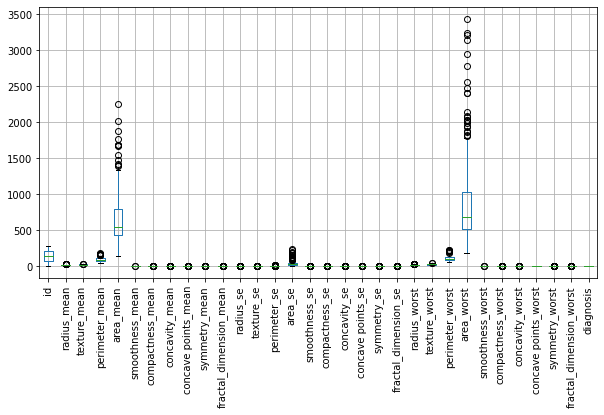

In [ ]:
data.loc[:,].boxplot(figsize=(10,5), rot=90)

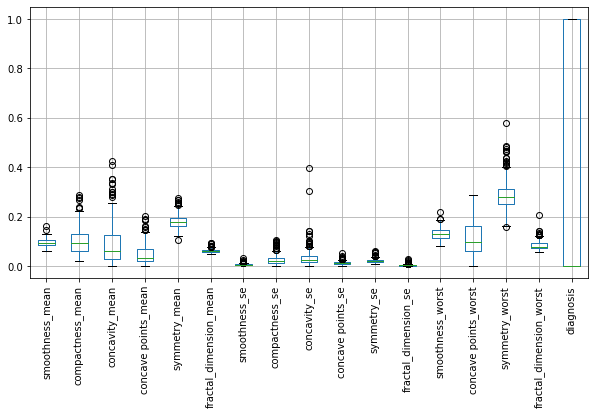

In [ ]:
data.loc[:, data.columns[data.max() <= 1].to_list()].boxplot(figsize=(10,5), rot=90)

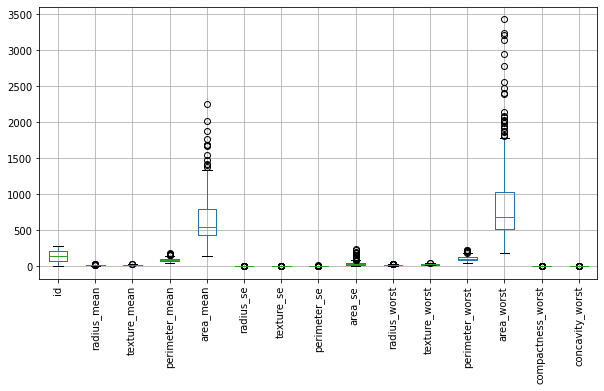

In [ ]:
data.loc[:, data.columns[data.max() > 1].to_list()].boxplot(figsize=(10,5), rot=90)

While there are outliers in this data they are fairly clustered thus probably valid data. Looking at the breakdown between values greater than 1 and those less than 1 we can see there is a good number of each thus some standardization may need to occur.

In [ ]:
features = data.columns[1:-1]
target = data.columns[-1]

X = data.loc[:, features]
y = data.loc[:, target]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, shuffle=True, stratify=y)

In [ ]:
# show balance of data in set
len(data[data['diagnosis']== 1])/len(data), len(data[data['diagnosis']== 0])/len(data)

(0.3732394366197183, 0.6267605633802817)

Of the five Naive Bayes models, Guassian is the only one not geared directly towards discrete values. Since that data in this set is not discrete, it would not make since to try the other 4.


Additional Standardization is not needed for Bayes since there is not reliance on distance. Adding in a MinMax Scaler or Standard Scaler has almsot not affect on the model.

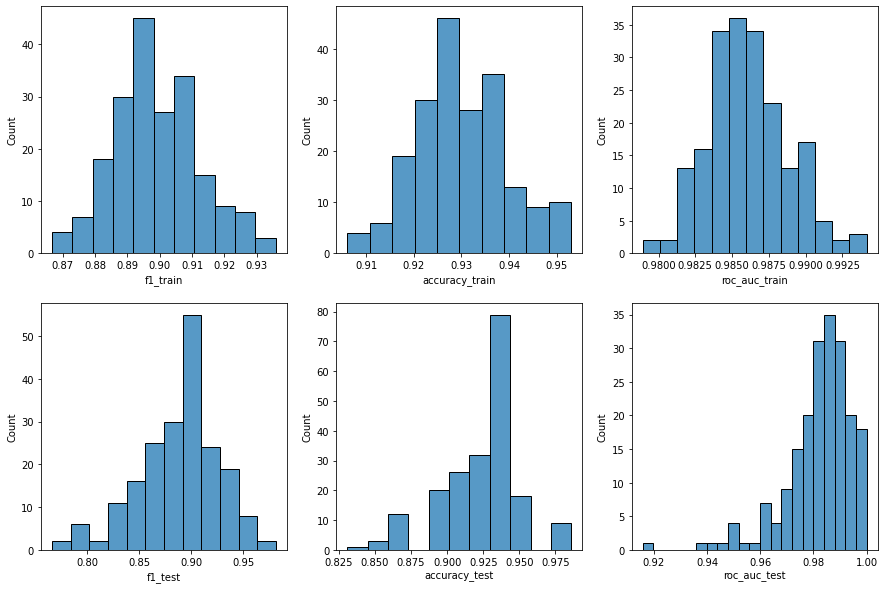

In [ ]:
def modelGBase(X, y):
  roc = []
  f1 = []
  accu =[]
  roc_test = []
  f1_test = []
  accu_test =[]

  for i in range(200):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, shuffle=True, stratify=y)

    model = make_pipeline(naive_bayes.GaussianNB())
    model.fit(X_train,y_train)

    prediction_test = model.predict(X_test)
    prob_prediction_test = model.predict_proba(X_test)[:,1]

    roc_test.append(metrics.roc_auc_score(y_test, prob_prediction_test))
    f1_test.append(metrics.f1_score(y_test, prediction_test))
    accu_test.append(metrics.accuracy_score(y_test, prediction_test))

    prediction = model.predict(X_train)
    prob_prediction = model.predict_proba(X_train)[:,1]

    roc.append(metrics.roc_auc_score(y_train, prob_prediction))
    f1.append(metrics.f1_score(y_train, prediction))
    accu.append(metrics.accuracy_score(y_train, prediction))

  return pd.DataFrame({'f1_train': f1, 'accuracy_train':accu, 'roc_auc_train':roc, 'f1_test':f1_test, 'accuracy_test':accu_test, 'roc_auc_test':roc_test})

scores = modelGBase(X, y)
plt.figure(figsize=(15,10))
for c in range(0, scores.shape[1]):
  plt.subplot(2, 3, c+1)
  sns.histplot(scores.iloc[:, c])

GaussianNB only really has one hyperparameter that can be done and it relates to how the smoothing will be done. 

In [ ]:
model = make_pipeline(naive_bayes.GaussianNB())

params = {'gaussiannb__var_smoothing': np.logspace(0,-9, num=100)}
model = GridSearchCV(model, param_grid=params, cv=10, scoring='f1')
model = model.fit(X_train, y_train)

model.best_estimator_, model.best_score_

(Pipeline(memory=None,
          steps=[('gaussiannb', GaussianNB(priors=None, var_smoothing=1e-09))],
          verbose=False), 0.8966666666666667)

In [ ]:
def modelDist(X, y, model):
  roc = []
  f1 = []
  accu =[]
  roc_test = []
  f1_test = []
  accu_test =[]

  for i in range(200):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, shuffle=True, stratify=y)

    model.fit(X_train,y_train)

    prediction_test = model.predict(X_test)
    prob_prediction_test = model.predict_proba(X_test)[:,1]

    roc_test.append(metrics.roc_auc_score(y_test, prob_prediction_test))
    f1_test.append(metrics.f1_score(y_test, prediction_test))
    accu_test.append(metrics.accuracy_score(y_test, prediction_test))

    prediction = model.predict(X_train)
    prob_prediction = model.predict_proba(X_train)[:,1]

    roc.append(metrics.roc_auc_score(y_train, prob_prediction))
    f1.append(metrics.f1_score(y_train, prediction))
    accu.append(metrics.accuracy_score(y_train, prediction))

  return pd.DataFrame({'f1_train': f1, 'accuracy_train':accu, 'roc_auc_train':roc, 'f1_test':f1_test, 'accuracy_test':accu_test, 'roc_auc_test':roc_test})


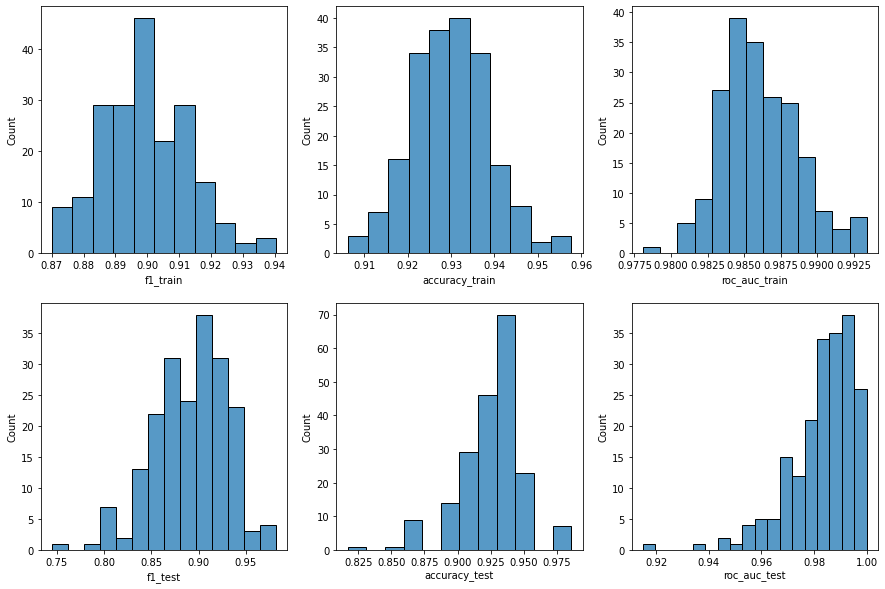

In [ ]:
scores = modelDist(X, y, model.best_estimator_)
plt.figure(figsize=(15,10))
for c in range(0, scores.shape[1]):
  plt.subplot(2, 3, c+1)
  sns.histplot(scores.iloc[:, c])


While standarding/normalizing isn't needed for Bayes, having features in a guassian formation is important. PowerTransformer helps with this issue by transforming the features into a more gaussian shapes. Below is a model exactly like the one above except it has the PowerTransformer.

In [ ]:
model2 = make_pipeline(PowerTransformer(), naive_bayes.GaussianNB())

params = {'gaussiannb__var_smoothing': np.logspace(0,-9, num=100)}
model2 = GridSearchCV(model2, param_grid=params, cv=10, scoring='f1')
model2 = model2.fit(X_train, y_train)

model2.best_estimator_, model2.best_score_

(Pipeline(memory=None,
          steps=[('powertransformer',
                  PowerTransformer(copy=True, method='yeo-johnson',
                                   standardize=True)),
                 ('gaussiannb',
                  GaussianNB(priors=None, var_smoothing=0.08111308307896872))],
          verbose=False), 0.9278991596638655)

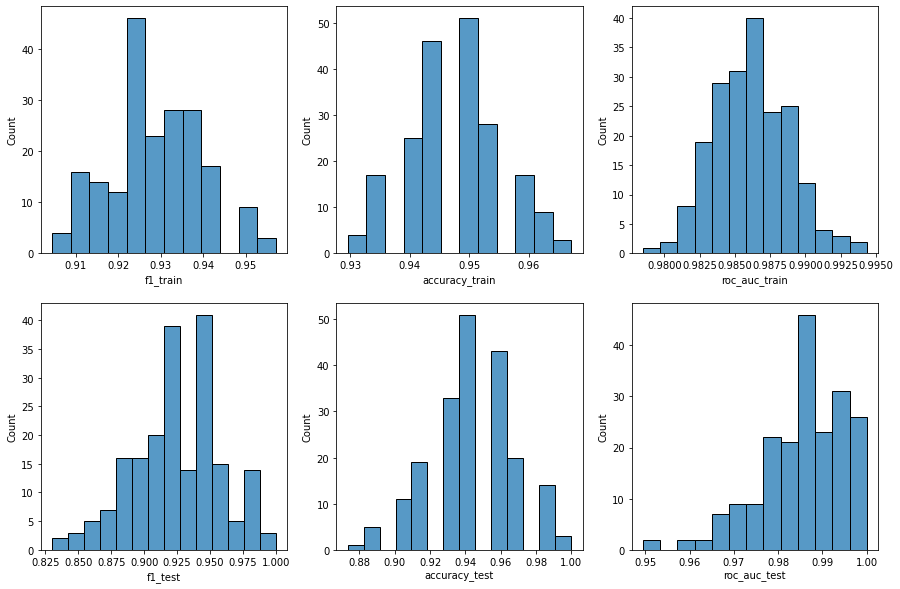

In [ ]:
scores = modelDist(X, y, model2.best_estimator_)
plt.figure(figsize=(15,10))
for c in range(0, scores.shape[1]):
  plt.subplot(2, 3, c+1)
  sns.histplot(scores.iloc[:, c])

The model above with the PowerTransformer is the best model found so far!

In [ ]:
test = pd.read_csv("test.csv")

featuresT = test.columns[1:]

testX = test.loc[:, features]

probTest = model2.predict(testX)

output = pd.DataFrame({'id': test.id, 'diagnosis': probTest})
output = output.astype(int)
output.to_csv('my_submission.csv', index=False)
